In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from tbats import TBATS
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
import holidays
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
import xgboost as xgb
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('LD2011_2014.txt', delimiter=';', index_col=0, parse_dates=True, decimal=',')

In [3]:
df.head(10)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 02:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 02:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Transform kW to kWh by dividing by 4 (assuming 15-minute intervals in a day)
df = df / 4
# Display basic statistics of the data
print(df.describe())

              MT_001         MT_002         MT_003         MT_004  \
count  140256.000000  140256.000000  140256.000000  140256.000000   
mean        0.992696       5.192120       0.729577      20.546123   
std         1.495991       3.318104       2.753614      14.562098   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.711238       0.000000       9.146341   
50%         0.317259       6.223329       0.434405      21.849593   
75%         0.634518       7.467994       0.434405      28.963415   
max        12.055838      28.805121      37.793223      80.284553   

              MT_005         MT_006         MT_007         MT_008  \
count  140256.000000  140256.000000  140256.000000  140256.000000   
mean        9.310077      35.306846       1.130334      47.850369   
std         6.615332      24.609996       1.621421      30.495297   
min         0.000000       0.000000       0.000000       0.000000   
25%         3.963415      17.8571

## Check missing data
though it's claimed that there is no missing value, there is still need to recheck

In [5]:
# Check for missing data
print('Number of missing values:', df.isnull().sum().sum())

Number of missing values: 0


## Remove Outliers

We've tried three different methods for removing outliers:

- Z-score

- IQR

- Hampel package

and finnally we selected IQR method as it IQR is less sensitive to extreme values compared to the Z-score method.
Also it computes very fast.

In [6]:
def correct_outliers_IQR(df):
    """
    Apply outlier correction technique to each column of the DataFrame independently.
    Replace outliers with the maximum Q3 and Q1 values of each column.

    Parameters:
    - df: pandas DataFrame

    Returns:
    - corrected_df: pandas DataFrame with outliers replaced
    - outlier_logs: dictionary containing information about outliers for each column
    """
    corrected_df = df.copy()  # Create a copy of the DataFrame to avoid modifying the original
    outlier_logs = {}  # Dictionary to store outlier information

    for column in corrected_df.columns:
        # Calculate Q1 and Q3 for the current column
        Q1 = corrected_df[column].quantile(0.25)
        Q3 = corrected_df[column].quantile(0.75)

        # Calculate Interquartile Range (IQR) for the current column
        IQR = Q3 - Q1

        # Define lower and upper bounds for outliers
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR

        # Find outliers in the current column
        outliers = corrected_df[(corrected_df[column] < lower_bound) | (corrected_df[column] > upper_bound)][column]

        # Replace outliers in the current column with maximum Q3 and Q1 values
        corrected_df.loc[corrected_df[column] < lower_bound, column] = Q1
        corrected_df.loc[corrected_df[column] > upper_bound, column] = Q3

        # Log outlier information
        outlier_logs[column] = {'outliers': outliers.tolist(), 'count': len(outliers)}

    # Convert outlier_logs dictionary to DataFrame
    outlier_logs_df = pd.DataFrame.from_dict(outlier_logs, orient='index')

    return corrected_df, outlier_logs_df

# Apply outlier correction to each column
corrected_df_iqr, outlier_logs_df_iqr = correct_outliers_IQR(df)

In [7]:
def correct_outliers_zscore(df):
    """
    Apply outlier correction technique to each column of the DataFrame independently using z-score.
    Replace outliers with the maximum Q3 and Q1 values of each column.

    Parameters:
    - df: pandas DataFrame

    Returns:
    - corrected_df: pandas DataFrame with outliers replaced
    - outlier_logs_df: pandas DataFrame containing outlier information for each column
    """
    corrected_df = df.copy()  
    outlier_logs = {} 
    for column in corrected_df.columns:
        z_scores = (corrected_df[column] - corrected_df[column].mean()) / corrected_df[column].std()

        threshold = 3

        outliers = corrected_df[abs(z_scores) > threshold][column]

        median_value = corrected_df[column].median()
        corrected_df.loc[abs(z_scores) > threshold, column] = median_value

        outlier_logs[column] = {'outliers': outliers.tolist(), 'count': len(outliers)}

    outlier_logs_df = pd.DataFrame.from_dict(outlier_logs, orient='index')

    return corrected_df, outlier_logs_df


corrected_df_zscore, outlier_logs_df_zscore = correct_outliers_zscore(df)

## Visualization

### Comparison of Removing Outlier Methods

In [8]:
print(len(outlier_logs_df_iqr)/len(df), len(outlier_logs_df_zscore)/len(df))

0.00263803331051791 0.00263803331051791


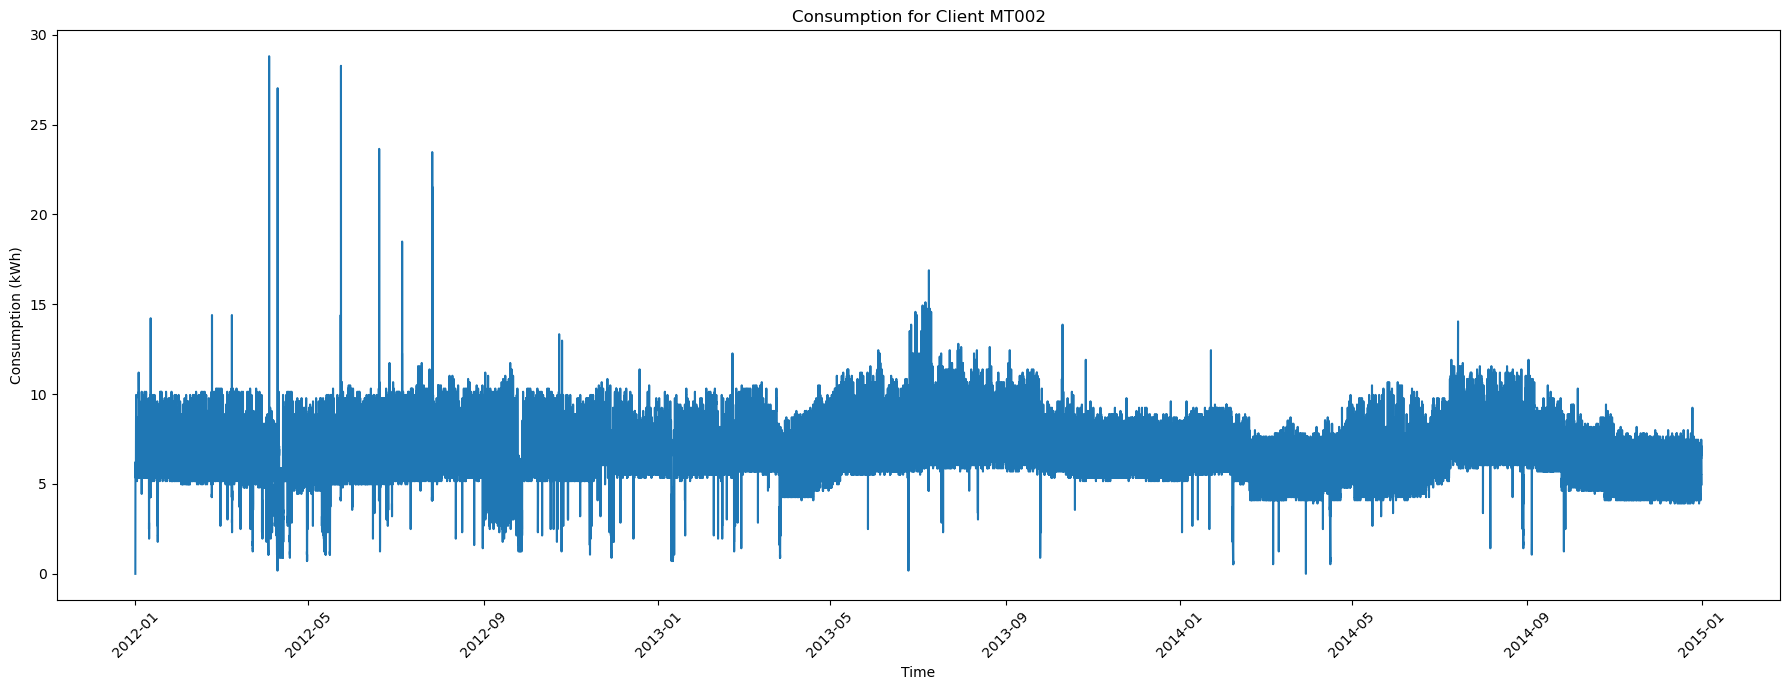

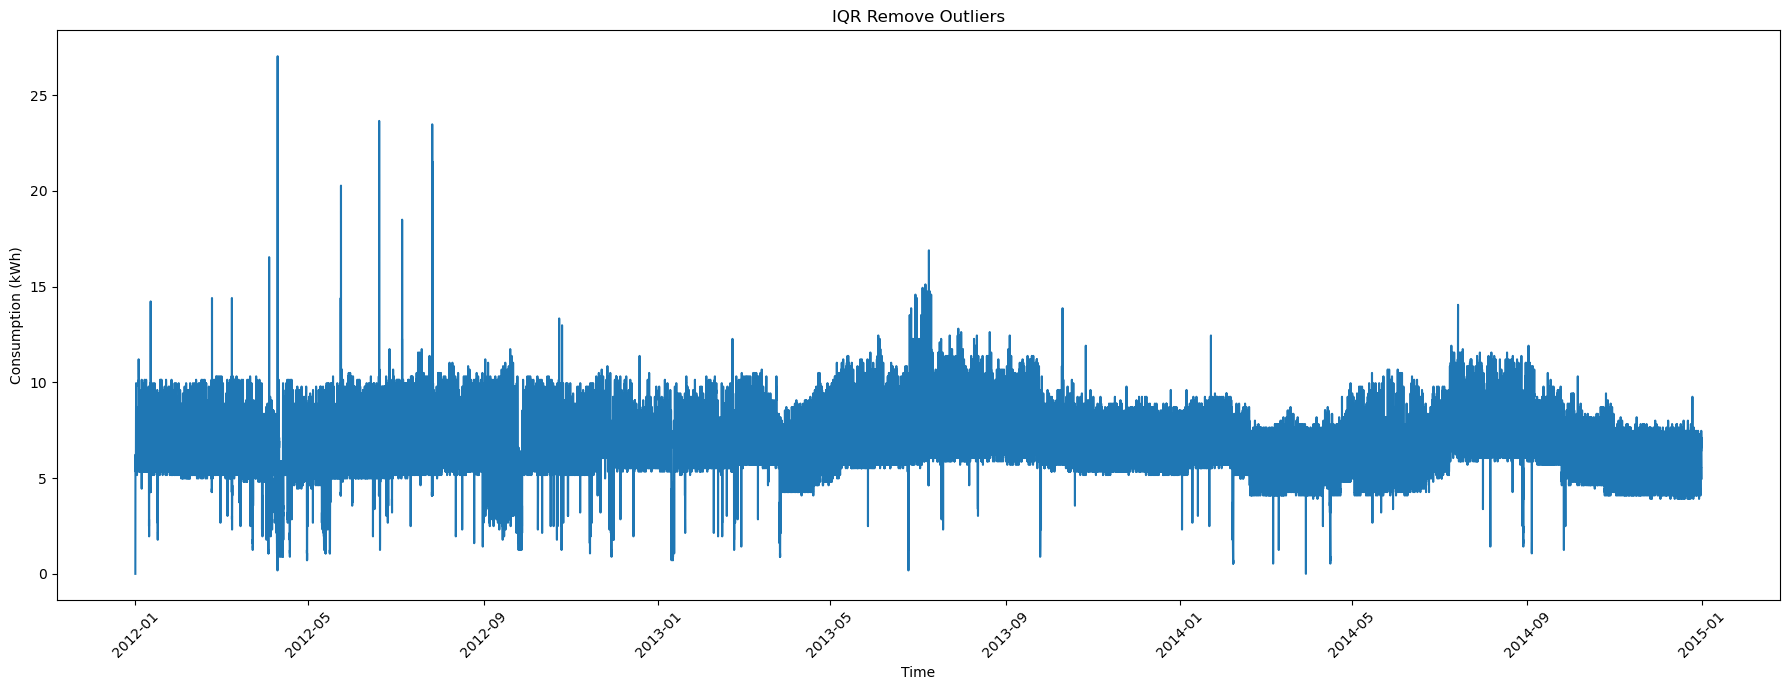

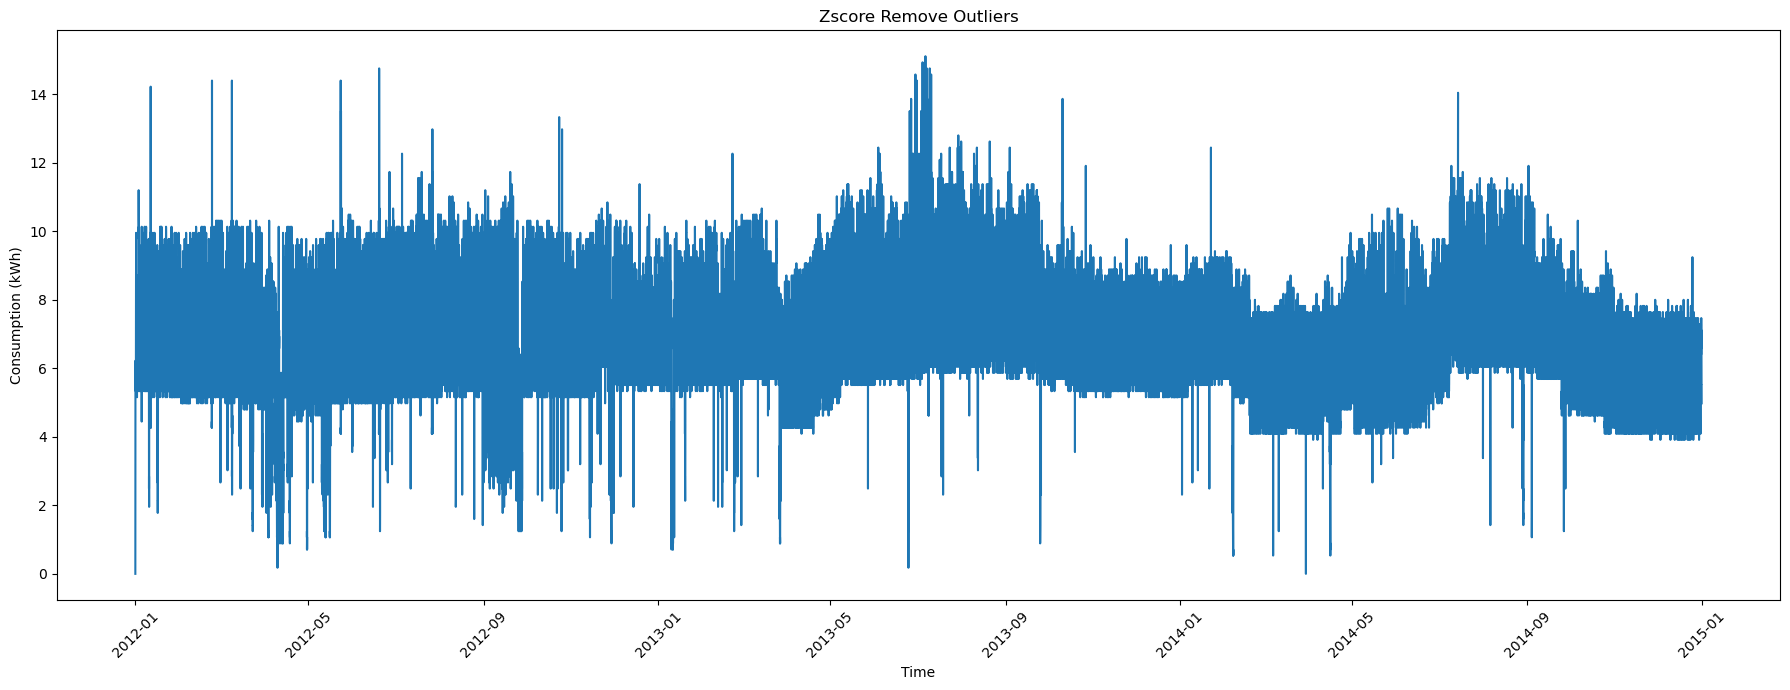

In [9]:
def plot_client_data(data, message):
  # Plotting
  plt.figure(figsize=(18,7))  
  plt.plot(data, linestyle='-')
  plt.title(message)
  plt.xlabel('Time')
  plt.ylabel('Consumption (kWh)')
  plt.xticks(rotation=45) 
  plt.tight_layout()  
  plt.show()

plot_client_data(df['MT_002']['2012':],'Consumption for Client MT002')
plot_client_data(corrected_df_iqr['MT_002']['2012':],'IQR Remove Outliers')
plot_client_data(corrected_df_zscore['MT_002']['2012':],'Zscore Remove Outliers')

### Daily/Weekly Trend

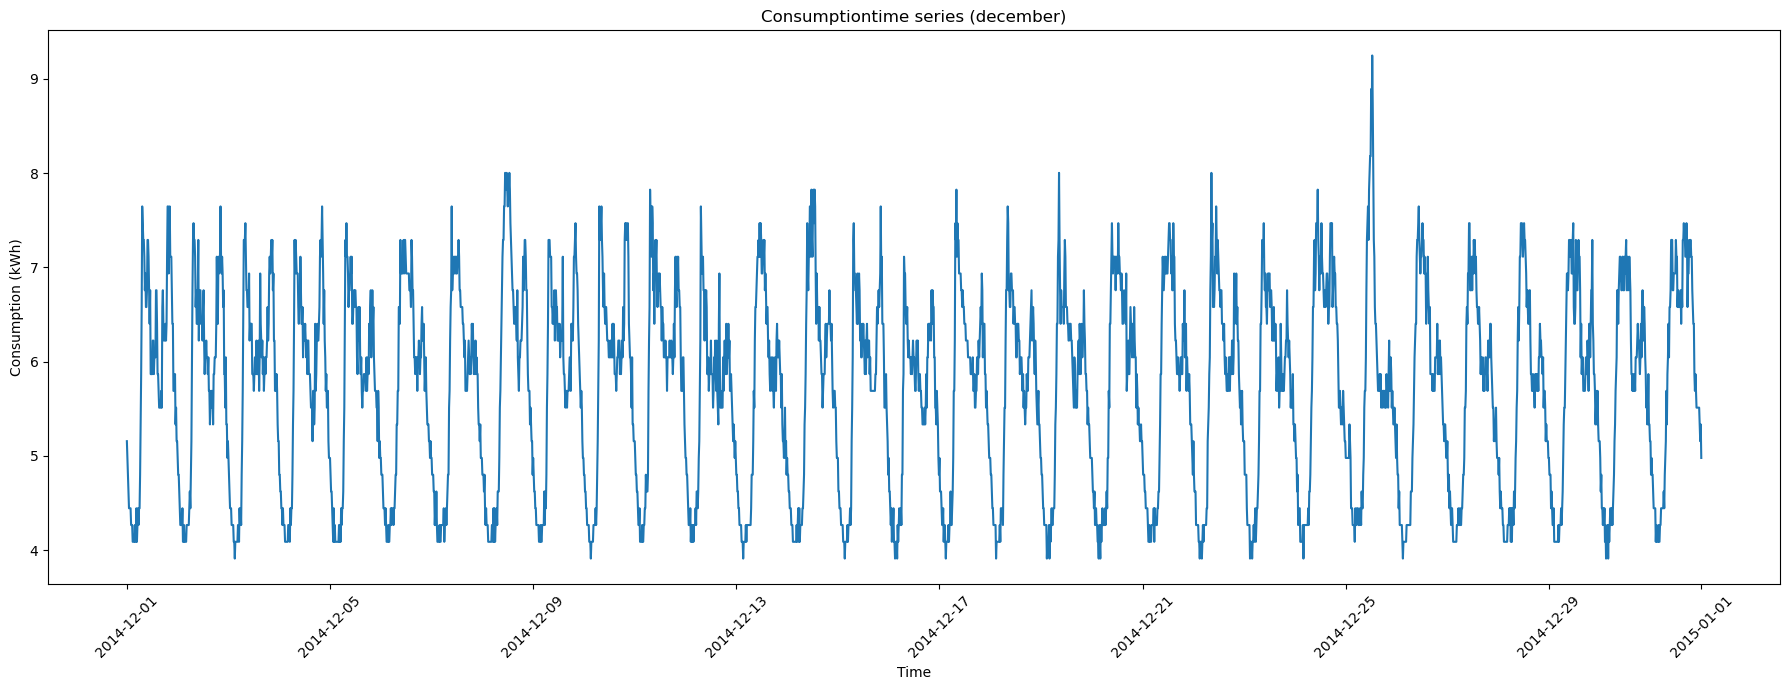

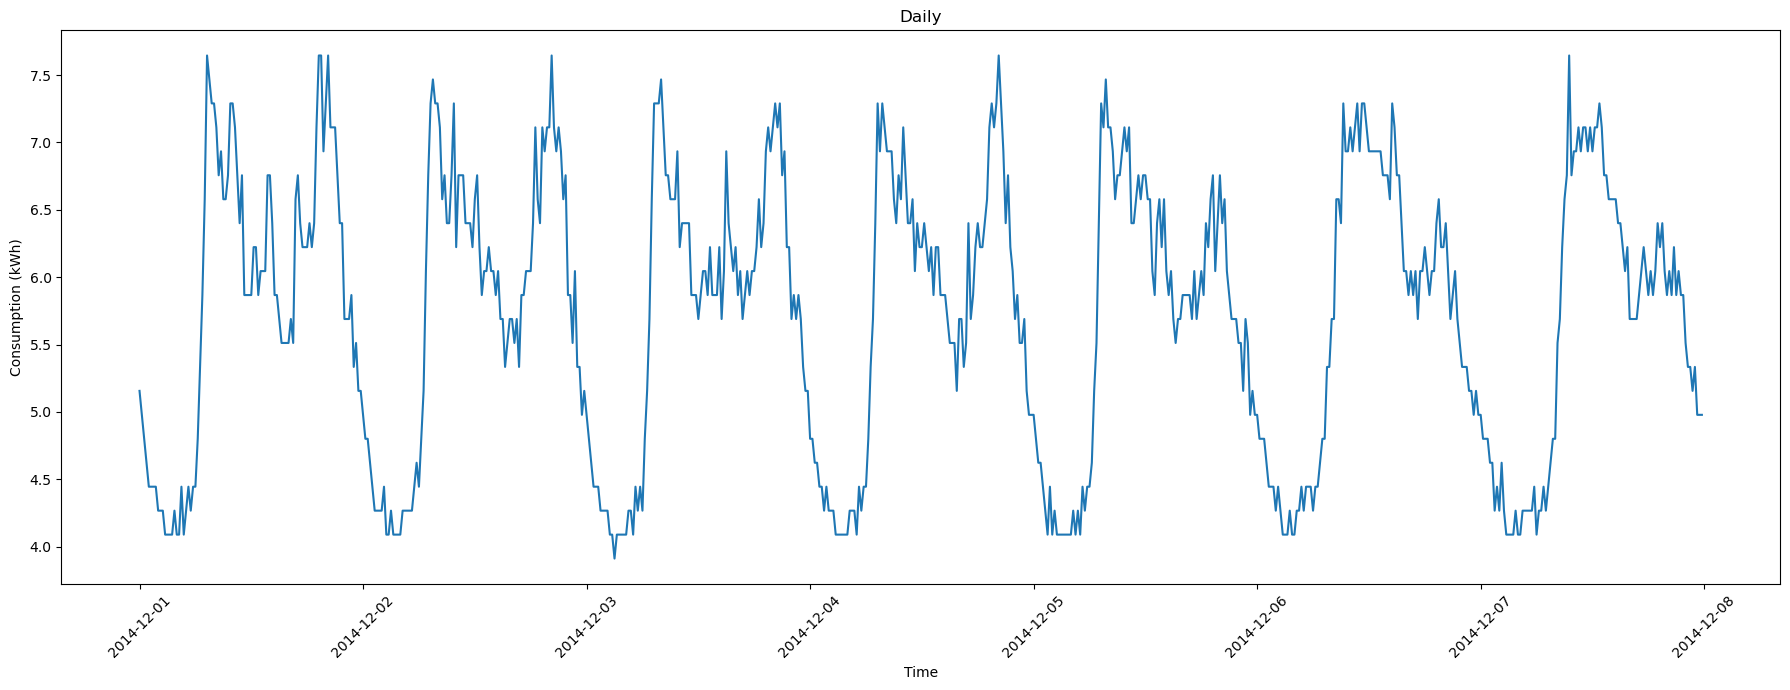

In [10]:
plot_client_data(corrected_df_iqr['MT_002']['2014-12-01 00:00:00':], 'Consumptiontime series (december)')
plot_client_data(corrected_df_iqr['MT_002']['2014-12-01':'2014-12-7'],'Daily')

### Autocorrelation analysis
The 144 lags seasonality (corresponding to one day) and the non-stationarity of the time series are shown below:

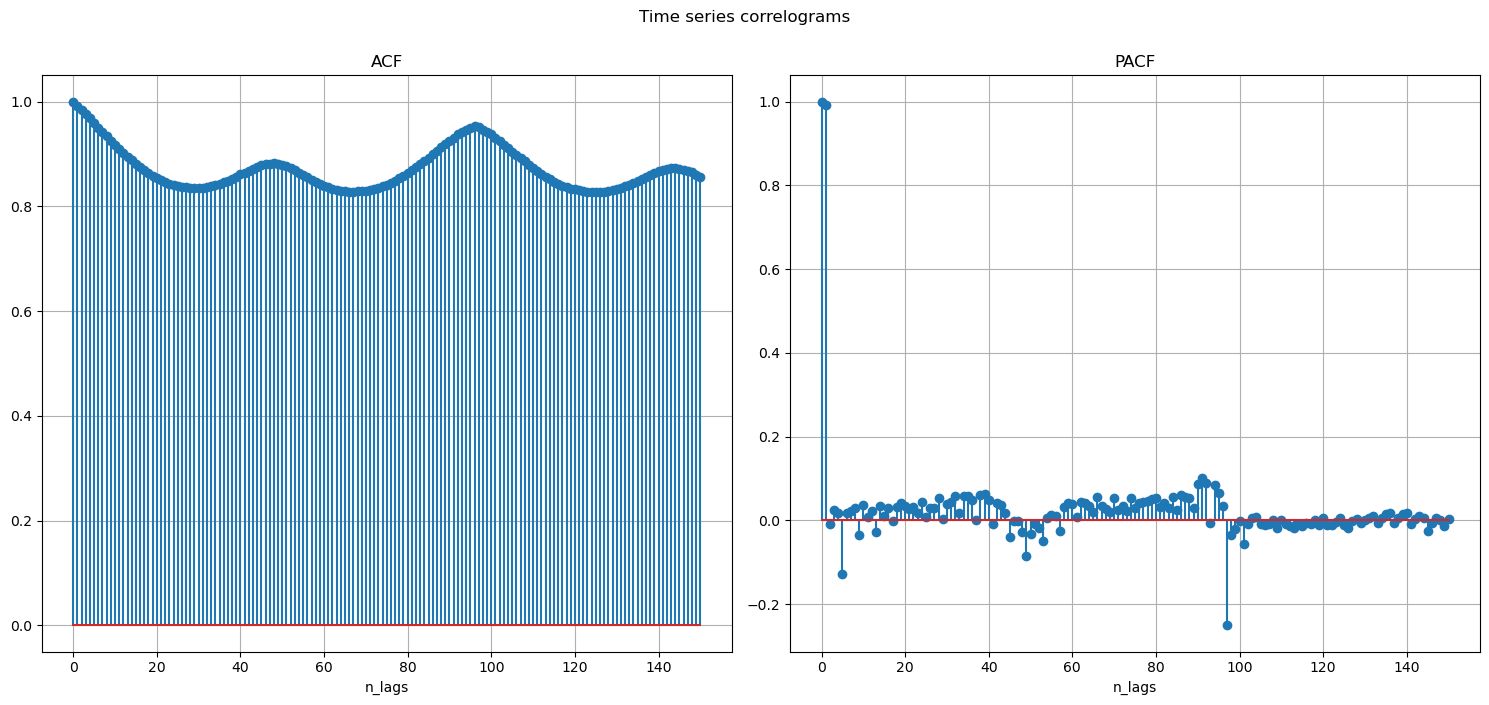

In [11]:
fas = sm.tsa.acf(corrected_df_iqr['MT_002'], nlags=150)
fap = sm.tsa.pacf(corrected_df_iqr['MT_002'], nlags=150)

fig, axs = plt.subplots(1, 2, figsize=(15,7))
fig.suptitle('Time series correlograms', y=1)
axs[0].stem(fas)
axs[0].set_title('ACF')
axs[0].set_xlabel('n_lags')
axs[0].grid(True)
axs[1].stem(fap)
axs[1].set_title('PACF')
axs[1].set_xlabel('n_lags')
axs[1].grid(True)
plt.tight_layout()
plt.show()

### Moving Average

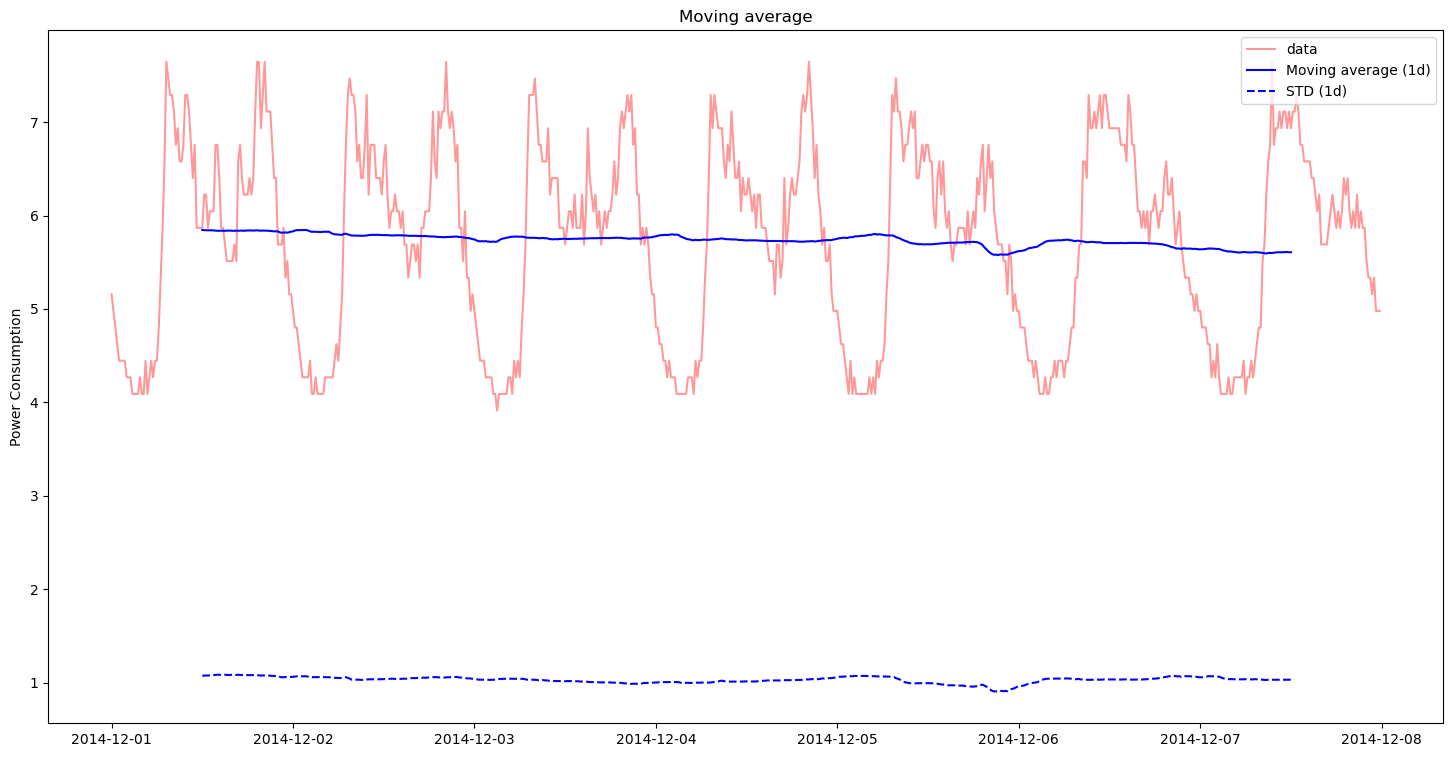

In [12]:
client2_dec =corrected_df_iqr['MT_002']['2014-12-01':'2014-12-7']
MMd = client2_dec.rolling(96, center=True).mean()
STDd = client2_dec.rolling(96, center=True).std()

plt.figure(figsize=(18,9))
plt.plot(client2_dec, linestyle='-', color='red', alpha=0.4, label='data')
plt.plot(MMd, linestyle='-', color='b', label='Moving average (1d)')
plt.plot(STDd, linestyle='--', color='b', label='STD (1d)')
plt.ylabel('Power Consumption')
plt.title('Moving average', y=1)
plt.legend()
plt.show()

### Seasonal Decompose

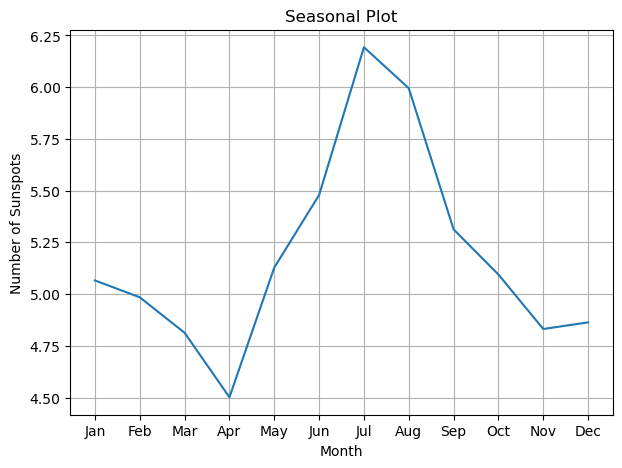

In [13]:
plt.figure(figsize=(7, 5))
sns.lineplot(x=corrected_df_iqr.index.month, y=corrected_df_iqr['MT_002'], ci=None)
plt.xlabel('Month')
plt.ylabel('Number of Sunspots')
plt.title('Seasonal Plot')
plt.xticks(range(1, 13), labels=[
           'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

<Figure size 2000x700 with 0 Axes>

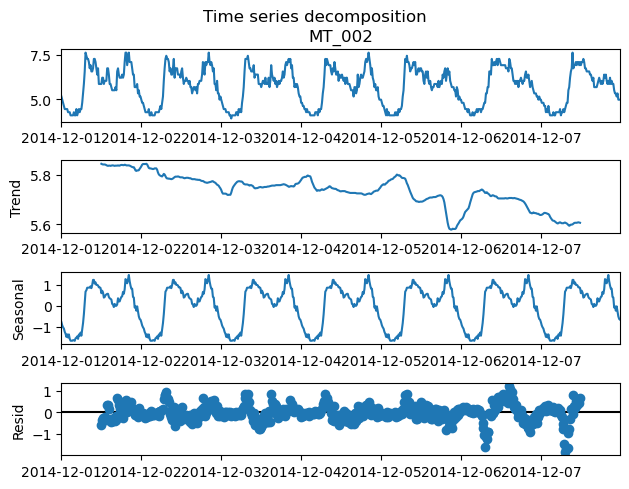

In [14]:
descomposicion_d = seasonal_decompose(client2_dec, model='aditive', period=96)
plt.figure(figsize=(20, 7))
descomposicion_d.plot().suptitle('Time series decomposition', y=1.01)
plt.show()

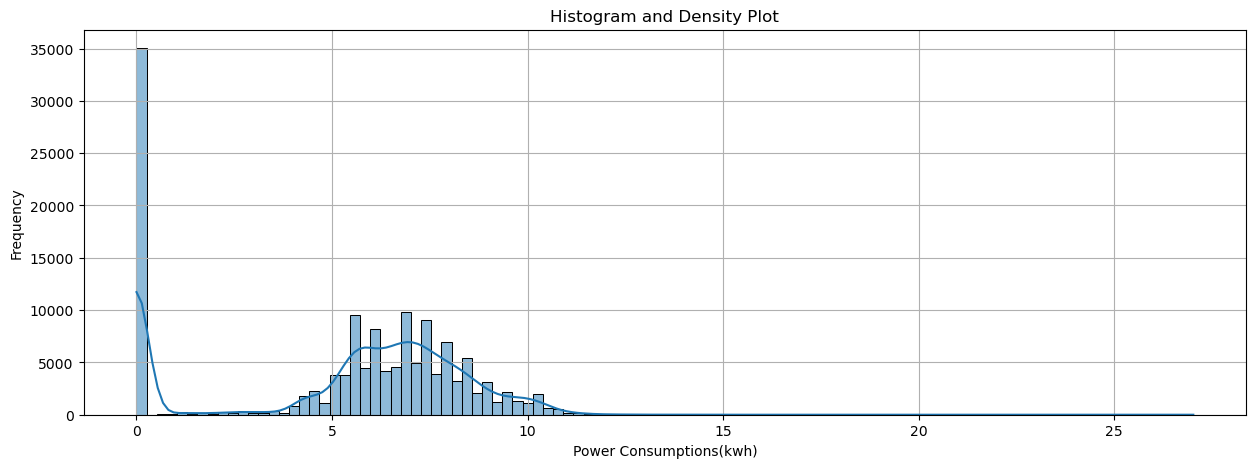

In [15]:
plt.figure(figsize=(15, 5))
sns.histplot(corrected_df_iqr['MT_002'], kde=True)
plt.xlabel('Power Consumptions(kwh)')
plt.ylabel('Frequency')
plt.title('Histogram and Density Plot')
plt.grid(True)
plt.show()

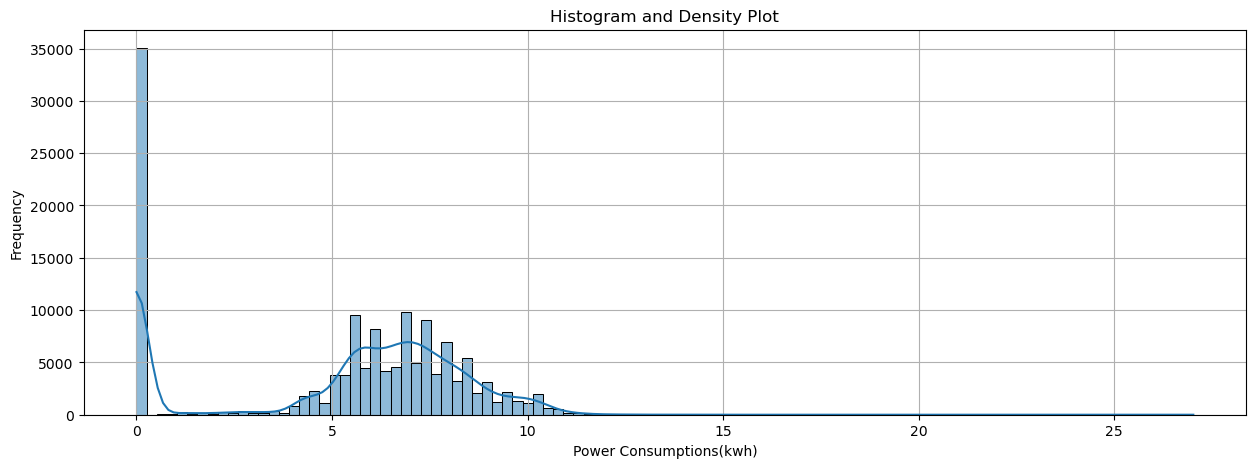

In [16]:
plt.figure(figsize=(15, 5))
sns.histplot(corrected_df_iqr['MT_002'], kde=True)
plt.xlabel('Power Consumptions(kwh)')
plt.ylabel('Frequency')
plt.title('Histogram and Density Plot')
plt.grid(True)
plt.show()

## Model Selection:

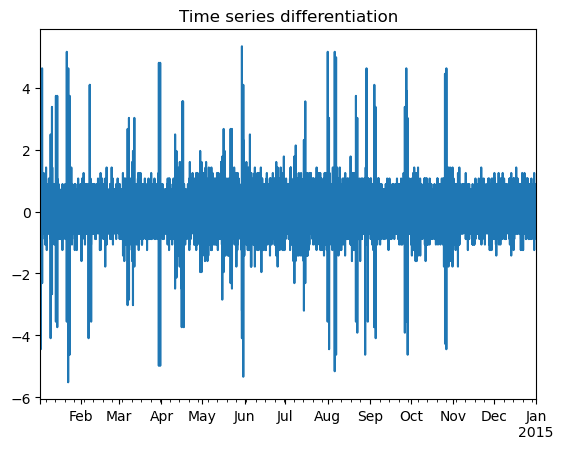

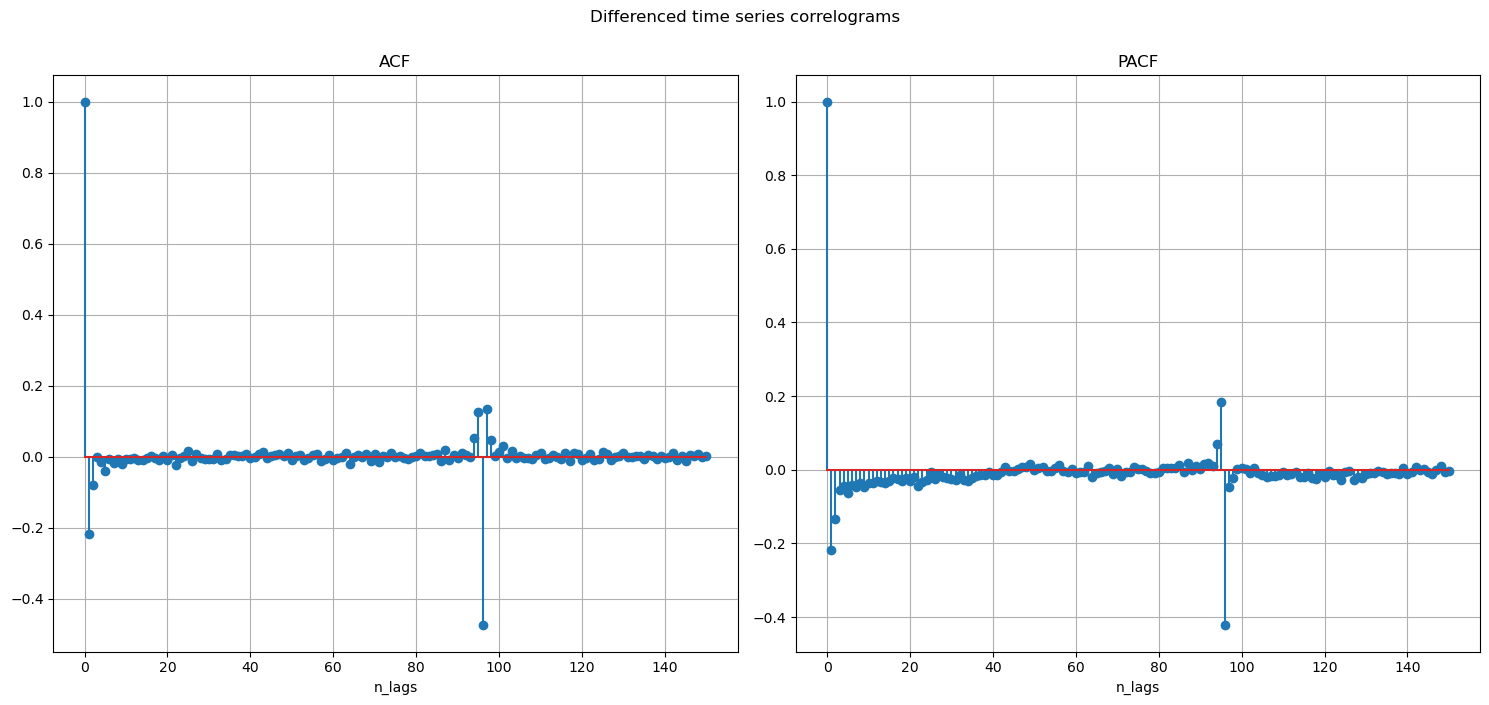

In [17]:
dif = sm.tsa.statespace.tools.diff(corrected_df_iqr['MT_002']['2014':], k_diff=1, k_seasonal_diff=1, seasonal_periods=96)
dif.plot()
plt.title('Time series differentiation')
plt.show()
fas_dif = sm.tsa.acf(dif, nlags=150)
fap_dif = sm.tsa.pacf(dif, nlags=150)

fig, axs = plt.subplots(1, 2, figsize=(15,7))
fig.suptitle('Differenced time series correlograms', y=1)
axs[0].stem(fas_dif)
axs[0].set_title('ACF')
axs[0].set_xlabel('n_lags')
axs[0].grid(True)
axs[1].stem(fap_dif)
axs[1].set_title('PACF')
axs[1].set_xlabel('n_lags')
axs[1].grid(True)
plt.tight_layout()
plt.show()

The parameter needs to be adjusted until the model achieve good results.

s: time series seasonality in number of lags (see ACF graph).

d and D: Differentiate the time series until it seems to be stationary (white noise).

p: First lag with PACF value (nearly) zero.

q: First lag with ACF value (nearly) zero.

P: P>0 if ACF>0 at lag=s; else P=0.

Q: Q>0 if ACF<0 at lag=s; else Q=0.

## Feature Engineering

In [18]:
df = corrected_df_iqr['MT_002']
df = df.reset_index()
df = df.rename(columns={'index': 'DateTime'})

Add time related feature and moving average to the data set.

In [19]:
df['year'] = df['DateTime'].dt.year
df['month'] = df['DateTime'].dt.month
df['day'] = df['DateTime'].dt.day
df['hour'] = df['DateTime'].dt.hour
df['day_of_week'] = df['DateTime'].dt.dayofweek
df['weekend'] = (df['DateTime'].dt.dayofweek >= 5).astype(int) # 1 if weekend
df['MT_ma_4'] = df['MT_002'].rolling(4).mean()

In [20]:
#Holidays
us_holidays = holidays.UnitedStates(years=range(df['DateTime'].dt.year.min(), df['DateTime'].dt.year.max()))

def is_holiday(date):
    return date in us_holidays

df['is_holiday'] = df['DateTime'].apply(is_holiday).astype(int)

In [21]:
df['MT_ma_4'] = df['MT_ma_4'].fillna(0)
df = df[df['year']>2011]
df.head(10)

,DateTime,MT_002,year,month,day,hour,day_of_week,weekend,MT_ma_4,is_holiday
35039,2012-01-01 00:00:00,0.000000,2012,1,1,0,6,1,0.000000,1
35040,2012-01-01 00:15:00,5.689900,2012,1,1,0,6,1,1.422475,1
35041,2012-01-01 00:30:00,5.689900,2012,1,1,0,6,1,2.844950,1
35042,2012-01-01 00:45:00,5.689900,2012,1,1,0,6,1,4.267425,1
35043,2012-01-01 01:00:00,5.689900,2012,1,1,1,6,1,5.689900,1
35044,2012-01-01 01:15:00,5.512091,2012,1,1,1,6,1,5.645448,1
35045,2012-01-01 01:30:00,5.689900,2012,1,1,1,6,1,5.645448,1
35046,2012-01-01 01:45:00,5.689900,2012,1,1,1,6,1,5.645448,1
35047,2012-01-01 02:00:00,6.223329,2012,1,1,2,6,1,5.778805,1
35048,2012-01-01 02:15:00,5.867710,2012,1,1,2,6,1,5.867710,1


## Train Test Split

Validation set will be splitted in individual models.

In [22]:
X = df.drop(['MT_002', 'DateTime'], axis=1)
y = df['MT_002']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Define MAPE

In [26]:
# Define a func to calbulate MAPE
def calculate_mape(actual, forecast):
    actual, forecast = np.array(actual), np.array(forecast)
    non_zero = actual != 0
    return np.mean(np.abs((actual[non_zero] - forecast[non_zero]) / actual[non_zero])) * 100

## Facebook Prophet

In [27]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df_prophet = df[['DateTime', 'MT_002']].rename(columns={'DateTime': 'ds', 'MT_002': 'y'})
df_prophet = df_prophet[['ds', 'y']]

total_rows = len(df_prophet)
train_end = int(0.8 * total_rows)

train_df_prophet = df_prophet.iloc[:train_end]
test_df_prophet = df_prophet.iloc[train_end:]

00:31:49 - cmdstanpy - INFO - Chain [1] start processing
00:32:09 - cmdstanpy - INFO - Chain [1] done processing


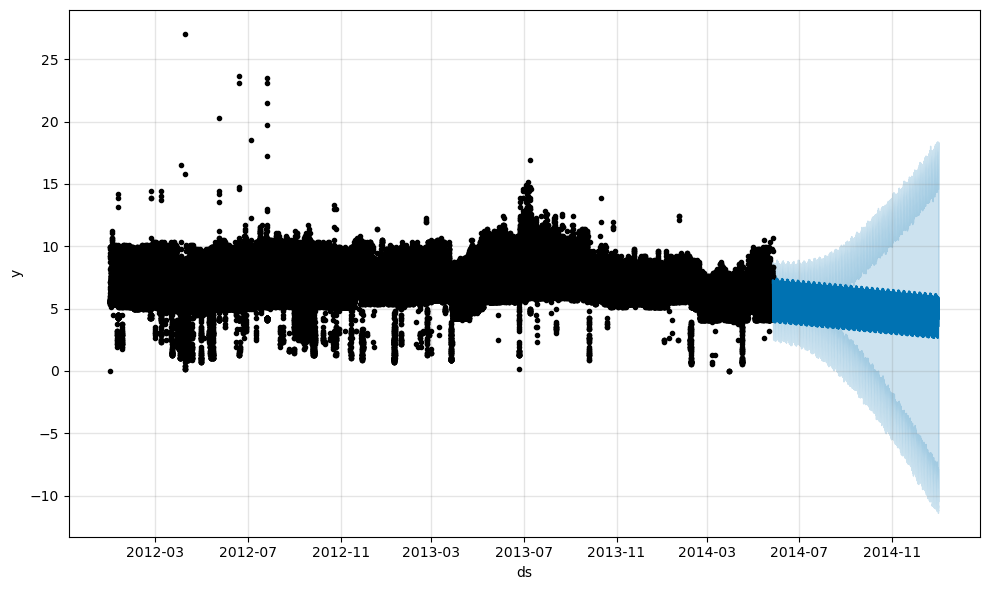

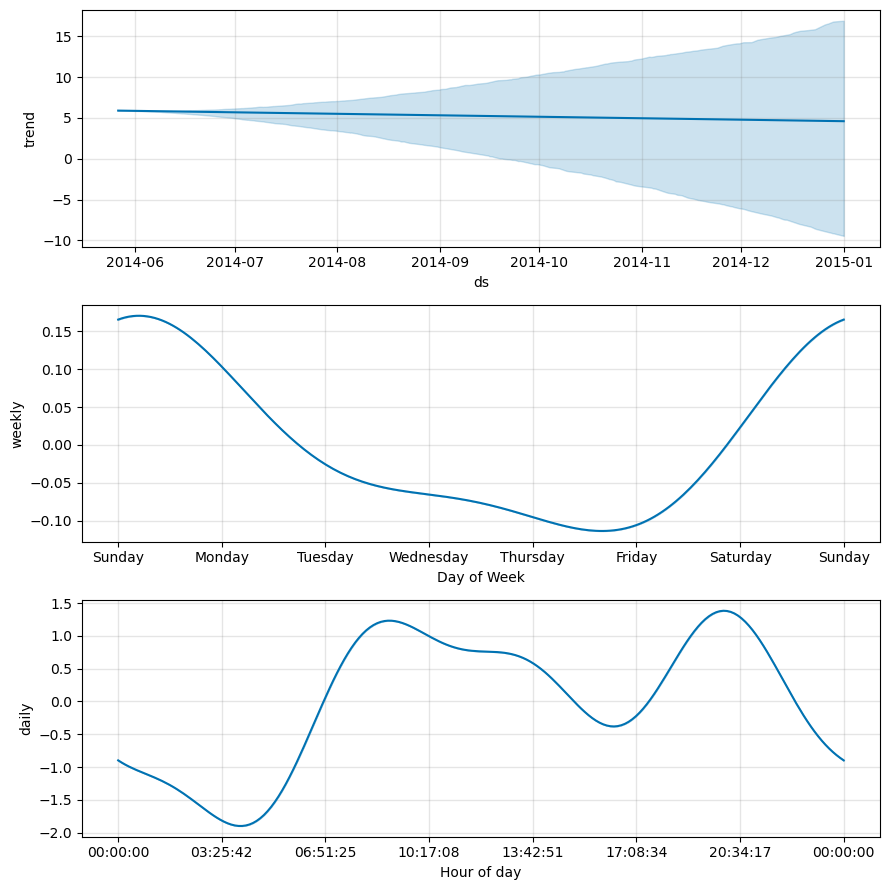

In [28]:
# Initialize the Prophet model with example hyperparameters
model = Prophet(
    growth='linear',                
    seasonality_mode='additive',   
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True,        
    changepoint_prior_scale=0.05    
)

# Fit the model
model.fit(train_df_prophet)
forecast = model.predict(test_df_prophet)

# Plot the forecast
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)

In [29]:
test_mape_fp = calculate_mape(test_df_prophet['y'], forecast['yhat'])
print(f"Test MAPE (Facebook Prophet): {test_mape_fp}%.")

Test MAPE (Facebook Prophet): 23.71822923336072%.


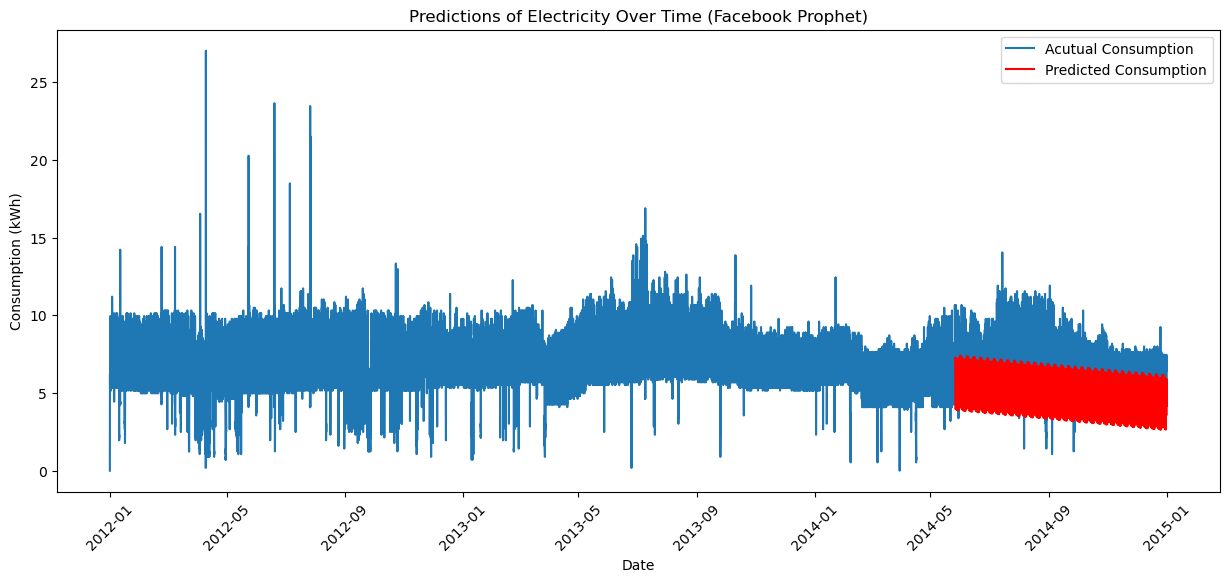

In [30]:
plt.figure(figsize=(15, 6))
plt.plot(df['DateTime'], df['MT_002'],linestyle='-', label="Acutual Consumption")
plt.plot(df['DateTime'][84173:], forecast['yhat'], color="red", label="Predicted Consumption")
plt.title('Predictions of Electricity Over Time (Facebook Prophet)')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

MAPE for Period 1: 22.775316456929456
MAPE for Period 2: 30.012721773788858
MAPE for Period 3: 18.365137553673534


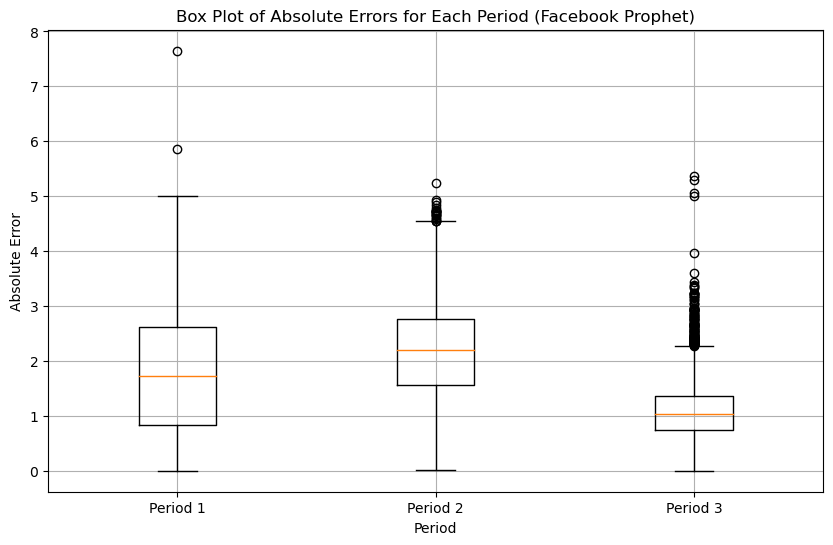

In [31]:
period_size = len(y_test) // 3
absolute_errors_periods_fp = []
for i in range(3):
    start_index = i * period_size
    end_index = (i + 1) * period_size if i < 3 else len(y_test)
    y_test_period = test_df_prophet[start_index:end_index].reset_index(drop=True)
    y_pred_period_fp = model.predict(y_test_period).reset_index(drop=True)
    absolute_errors_fp = abs(y_test_period['y'] - y_pred_period_fp['yhat'])
    absolute_errors_periods_fp.append(absolute_errors_fp)
    mape_period_fp = calculate_mape(y_test_period['y'], y_pred_period_fp['yhat'])
    print(f"MAPE for Period {i+1}: {mape_period_fp}")

plt.figure(figsize=(10, 6))
boxplot_fp = plt.boxplot(absolute_errors_periods_fp, labels=[f"Period {i+1}" for i in range(3)])

plt.title("Box Plot of Absolute Errors for Each Period (Facebook Prophet)")
plt.xlabel("Period")
plt.ylabel("Absolute Error")
plt.grid(True)
plt.show()

## Elastic-Net Regularization

The pro is short computation time!

In [32]:
# Define the parameter grid for Elastic Net
en_grid = {
    'alpha': [0.1, 1],
    'l1_ratio': [0.1, 0.5, 0.9]
}

# Prepare the cross-validation method
tscv = TimeSeriesSplit(n_splits=5)
mape_scorer = make_scorer(mean_absolute_percentage_error)

# Elastic Net grid search
elastic_net = ElasticNet()
en_grid_search = GridSearchCV(estimator=elastic_net, param_grid=en_grid, cv=tscv, scoring=mape_scorer, verbose=1)
en_grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_en_params = en_grid_search.best_params_
print(f"Best Elastic Net Hyperparameters: {best_en_params}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Elastic Net Hyperparameters: {'alpha': 1, 'l1_ratio': 0.9}


In [33]:
# Evaluate the best Elastic Net model on the test set
best_en_model = ElasticNet(**best_en_params)
best_en_model.fit(X_train, y_train)
y_test_pred_en = best_en_model.predict(X_test)
test_mape_en = calculate_mape(y_test, y_test_pred_en)
print(f"Test MAPE (Elastic Net): {test_mape_en}%.")

Test MAPE (Elastic Net): 8.225394112122986%.


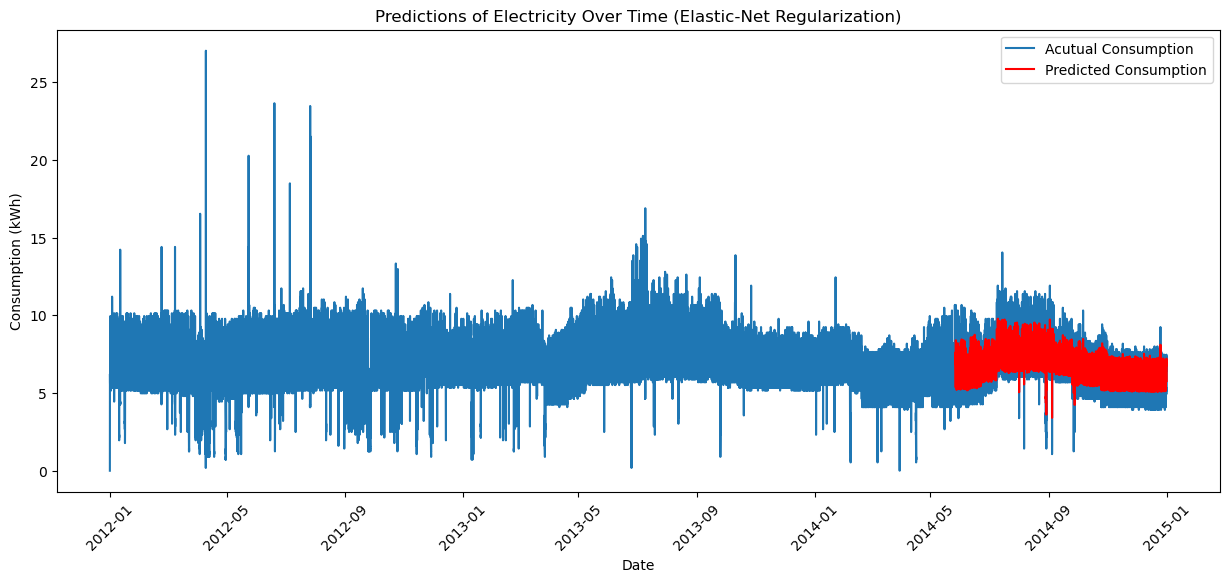

In [34]:
plt.figure(figsize=(15, 6))
plt.plot(df['DateTime'], df['MT_002'],linestyle='-', label="Acutual Consumption")
plt.plot(df['DateTime'][84173:], y_test_pred_en, color="red", label="Predicted Consumption")
plt.title('Predictions of Electricity Over Time (Elastic-Net Regularization)')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

MAPE for Period 1: 7.125841875752325
MAPE for Period 2: 7.376575972434013
MAPE for Period 3: 10.17192345918751


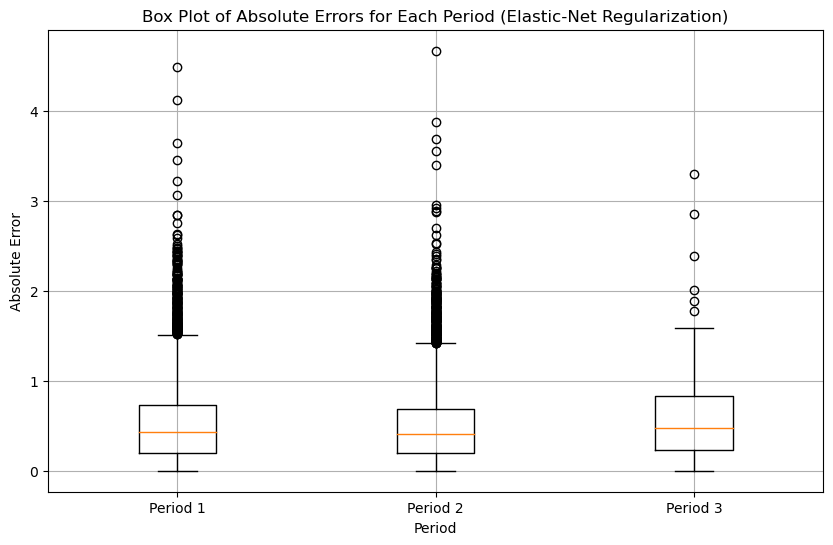

In [35]:
absolute_errors_periods_en = []
for i in range(3):
    start_index = i * period_size
    end_index = (i + 1) * period_size if i < 3 else len(y_test)
    X_test_period = X_test[start_index:end_index]
    y_test_period = y_test[start_index:end_index]
    y_pred_period_en = best_en_model.predict(X_test_period)
    absolute_errors_en = abs(y_test_period - y_pred_period_en)
    absolute_errors_periods_en.append(absolute_errors_en)
    mape_period_en = calculate_mape(y_test_period, y_pred_period_en)
    print(f"MAPE for Period {i+1}: {mape_period_en}")

plt.figure(figsize=(10, 6))
boxplot_en = plt.boxplot(absolute_errors_periods_en, labels=[f"Period {i+1}" for i in range(3)])

plt.title("Box Plot of Absolute Errors for Each Period (Elastic-Net Regularization)")
plt.xlabel("Period")
plt.ylabel("Absolute Error")
plt.grid(True)
plt.show()

## Random Forest

In [36]:
rf_grid = {
    "n_estimators": [10, 50, 100, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10]
}

tscv = TimeSeriesSplit(n_splits=5)
mape_scorer = make_scorer(mean_absolute_percentage_error)

# Random Forest grid search
rf = RandomForestRegressor()
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_grid, cv=tscv, scoring=mape_scorer, verbose=1)
rf_grid_search.fit(X_train, y_train)
best_rf_params = rf_grid_search.best_params_
print(f"Best Random Forest Hyperparameters: {best_rf_params}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Random Forest Hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 50}


In [37]:
# Random Forest
best_rf = RandomForestRegressor(**best_rf_params)
best_rf.fit(X_train, y_train)
y_test_pred_rf = best_rf.predict(X_test)
test_mape_rf = calculate_mape(y_test,y_test_pred_rf)
print(f"Test MAPE (Random Forest): {test_mape_rf}%.")

Test MAPE (Random Forest): 5.3114840915828365%.


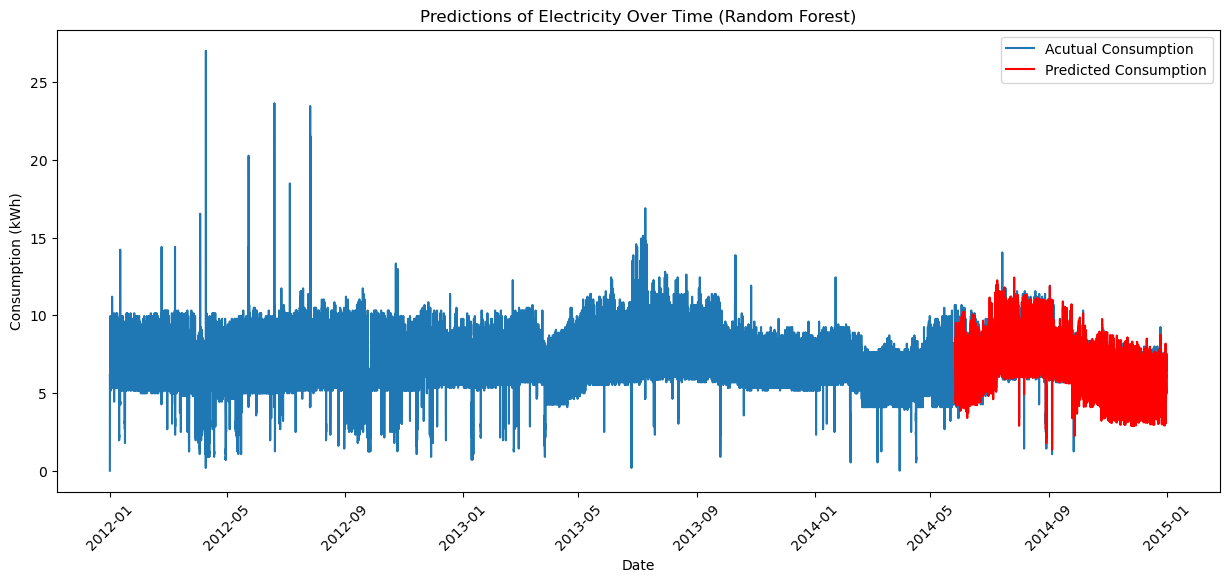

In [38]:
plt.figure(figsize=(15, 6))
plt.plot(df['DateTime'], df['MT_002'],linestyle='-', label="Acutual Consumption")
plt.plot(df['DateTime'][84173:], y_test_pred_rf, color="red", label="Predicted Consumption")
plt.title('Predictions of Electricity Over Time (Random Forest)')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

MAPE for Period 1: 4.5136576988828265
MAPE for Period 2: 4.307318139329459
MAPE for Period 3: 7.113751786053833


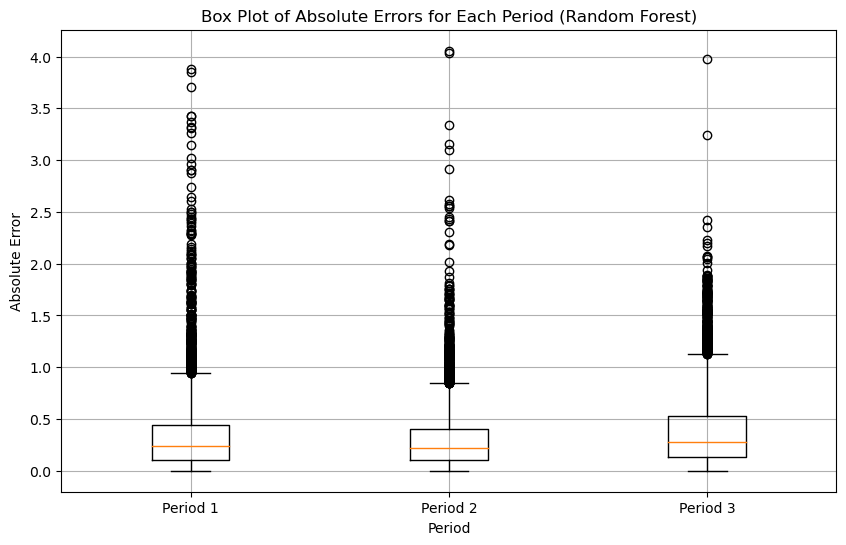

In [39]:
period_size = len(y_test) // 3
absolute_errors_periods_rf = []
for i in range(3):
    start_index = i * period_size
    end_index = (i + 1) * period_size if i < 3 else len(y_test)
    X_test_period = X_test[start_index:end_index]
    y_test_period = y_test[start_index:end_index]
    y_pred_period_rf = best_rf.predict(X_test_period)
    absolute_errors_rf = abs(y_test_period - y_pred_period_rf)
    absolute_errors_periods_rf.append(absolute_errors_rf)
    mape_period_rf = calculate_mape(y_test_period, y_pred_period_rf)
    print(f"MAPE for Period {i+1}: {mape_period_rf}")

plt.figure(figsize=(10, 6))
boxplot_rf = plt.boxplot(absolute_errors_periods_rf, labels=[f"Period {i+1}" for i in range(3)])

plt.title("Box Plot of Absolute Errors for Each Period (Random Forest)")
plt.xlabel("Period")
plt.ylabel("Absolute Error")
plt.grid(True)
plt.show()

## XG Boost

In [40]:
xgb_grid = {
    "max_depth": [2, 4, 6, 8],
    "n_estimators": [50, 100, 300, 500, 1000],
    "learning_rate": [0.02, 0.05, 0.1]
}

xgbr = xgb.XGBRegressor(eval_metric='mape')
tscv = TimeSeriesSplit(n_splits=5)
mape_scorer = make_scorer(mean_absolute_percentage_error)
grid_search = GridSearchCV(estimator=xgbr, param_grid=xgb_grid, cv=tscv, scoring=mape_scorer, verbose=1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Hyperparameters: {'learning_rate': 0.02, 'max_depth': 2, 'n_estimators': 50}


In [41]:
final_model = xgb.XGBRegressor(**best_params, eval_metric='mape')
final_model.fit(X_train, y_train, verbose=True)
y_test_pred_xg = final_model.predict(X_test)
test_mape_xg = calculate_mape(y_test, y_test_pred_xg)
print(f"Test MAPE: {test_mape_xg}%.")

Test MAPE: 8.777606112281429%.


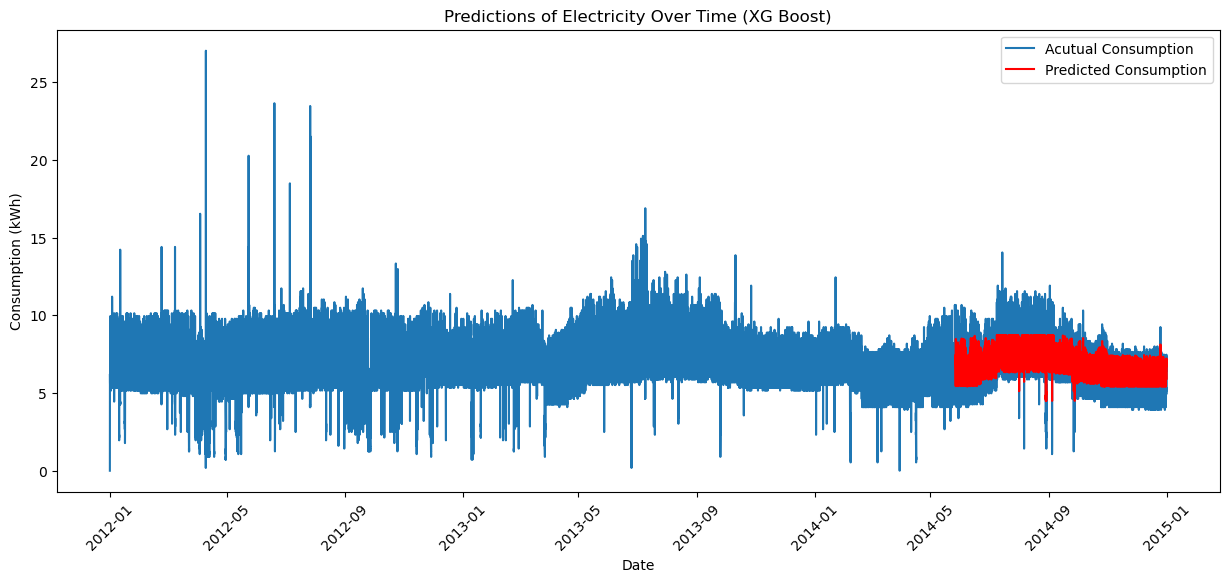

In [42]:
plt.figure(figsize=(15, 6))
plt.plot(df['DateTime'], df['MT_002'],linestyle='-', label="Acutual Consumption")
plt.plot(df['DateTime'][84173:], y_test_pred_xg, color="red", label="Predicted Consumption")
plt.title('Predictions of Electricity Over Time (XG Boost)')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

MAPE for Period 1: 7.530763790078911
MAPE for Period 2: 7.903434790394721
MAPE for Period 3: 10.896703224319216


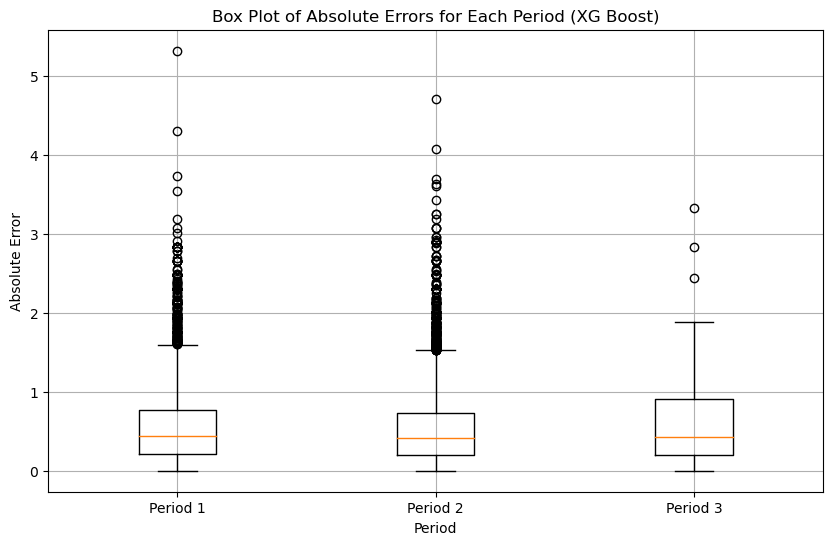

In [43]:
absolute_errors_periods_xg = []
for i in range(3):
    start_index = i * period_size
    end_index = (i + 1) * period_size if i < 3 else len(y_test)
    X_test_period = X_test[start_index:end_index]
    y_test_period = y_test[start_index:end_index]
    y_pred_period_xg = final_model.predict(X_test_period)
    absolute_errors_xg = abs(y_test_period - y_pred_period_xg)
    absolute_errors_periods_xg.append(absolute_errors_xg)
    mape_period_xg = calculate_mape(y_test_period, y_pred_period_xg)
    print(f"MAPE for Period {i+1}: {mape_period_xg}")

plt.figure(figsize=(10, 6))
boxplot_xg = plt.boxplot(absolute_errors_periods_xg, labels=[f"Period {i+1}" for i in range(3)])

plt.title("Box Plot of Absolute Errors for Each Period (XG Boost)")
plt.xlabel("Period")
plt.ylabel("Absolute Error")
plt.grid(True)
plt.show()

## Results

| Model | Best Hyper-parameter         | Best Test MAPE |  Period 1 Test MAPE | Period 2 Test MAPE | Period 3 Test MAPE | 
|----------|----------|----------|----------|----------|----------|
| Facebook Prophet |{'changepoint_prior_scale': 0.05} | 23.72% | 22.78% | 30.01% | 18.37% |
| Elastic Net Regression | {'alpha': 1, 'l1_ratio': 0.9}  | 8.23% | 7.13% | 7.38% | 10.17% | 
| Random Forest | {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 50}  | 5.31% | 4.51% | 4.31% | 7.11% |
| XGBoost | {'learning_rate': 0.02, 'max_depth': 2, 'n_estimators': 50}  | 8.78% | 7.53% | 7.90% | 10.90% | 

Random Forest model appears to have the best test MAPE. Here is the feature important graph of random forest.

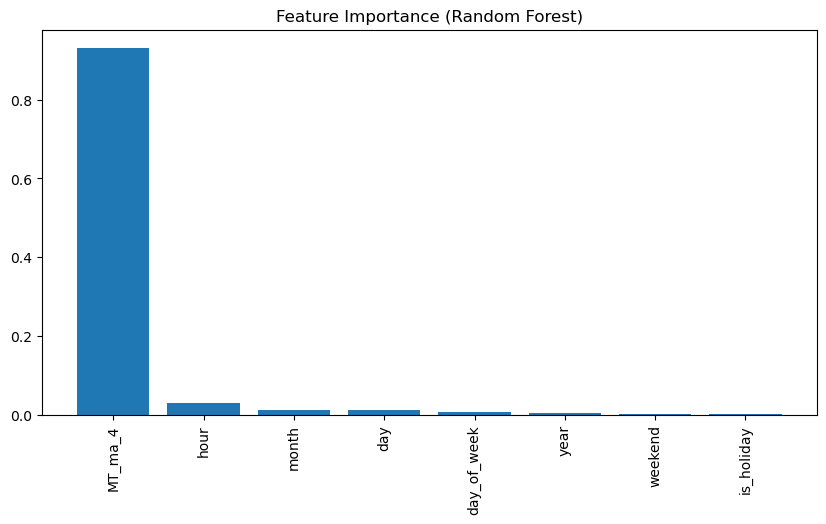

In [44]:
feature_importances = best_rf.feature_importances_
feature_names = X_train.columns

indices = np.argsort(feature_importances)[::-1]
names = [feature_names[i] for i in indices]

plt.figure(figsize=(10, 5))
plt.title("Feature Importance (Random Forest)")

plt.bar(range(X_train.shape[1]), feature_importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=90)

plt.show()